In [1]:
import torch 
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Configuration environment
import os

os.environ['KAGGLE_USERNAME'] = "karandeepbhardwaj" # username from the json file
os.environ['KAGGLE_KEY'] = "a188728f8e2873a3cd0394bd2b543ffb" # key from the json file
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip -d my_data

Streaming output truncated to the last 5000 lines.
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: my_data/Face Mask Dataset/Train/WithoutMask/1868.png

In [14]:
#Data Loading
classes = ['NotMasked', 'Masked', 'NotHuman']

REBUILD_DATA = True
lead_path = './my_data/Face Mask Dataset/Train/'

if REBUILD_DATA: #if we are running it for the first time
    # data_path = Path(lead_path)
    maskPath = './my_data/Face Mask Dataset/Train/Mask'
    #maskPath2= data_path/'Mask'
    nonMaskPath = './my_data/Face Mask Dataset/Train/NoMask'
    # notHumanPath = data_path/'NotHuman'
    maskDF = pd.DataFrame() 
    path_dirs = [ [maskPath,1],[nonMaskPath,0] ] #path and label
    if not os.path.exists(lead_path):
        raise Exception("The data path doesn't exist")

In [15]:
class MaskvNoMask():
    IMG_SIZE = 100
    LABELS = {'NON_MASKED': 0, 'MASKED': 1}
    training_data = []
    
    count = 0
    
    def make_training_data(self):
        for data_dir, label in path_dirs:
            print('Reading from: ',label)
            for folder in tqdm(os.listdir(data_dir)):
                folder_path = os.path.join(data_dir, folder)
                for imgpath in os.listdir(folder_path):
                    self.count += 1                       
                    img_path = os.path.join(folder_path, imgpath)
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                        self.training_data.append([np.array(img), label])
                        self.count +=1
                        
                        if label == 1:
                            self.LABELS['MASKED'] += 1
                        if label == 0:
                            self.LABELS['NON_MASKED'] +=1
                            
                        if self.count > 1000000:
                            self.count = 0
                            np.random.shuffle(self.training_data)
                            np.save("./npy/training_data.npy", self.training_data)
                            return
                    except:
#                         raise Exception('error: {}'.format(img_path))
                        pass
            print(self.LABELS)
#                         raise Exception('error occured while reading , {}'.format(os.path.join(maskPath, os.path.join(subject, imgPath))))
                        
        
        np.random.shuffle(self.training_data)
        # np.save("./npy/training_data.npy", self.training_data)
        
if REBUILD_DATA:
    maskvnomask = MaskvNoMask()
    maskvnomask.make_training_data()
    training_data = maskvnomask.training_data
else:
    training_data = np.load('./npy/training_data.npy', allow_pickle=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Reading from:  1


  0%|          | 0/1 [00:00<?, ?it/s]

{'NON_MASKED': 0, 'MASKED': 5001}
Reading from:  0


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

{'NON_MASKED': 5000, 'MASKED': 5001}


In [16]:
training_data[10][0].shape

(100, 100, 3)

NotMasked


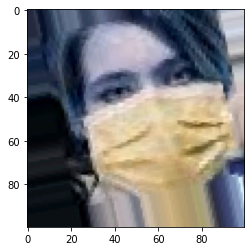

In [17]:
plt.imshow(training_data[4][0])
print(classes[training_data[1][1]])

In [18]:
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor

In [19]:
class MaskDataset(Dataset):
        """ Masked faces dataset
        0 = 'no mask'
        1 = 'mask'
        """
        def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor(), # [0, 1]
            ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('slicing is not supported')                    
            return [
                self.transformations(self.train_data[key][0]),
                torch.tensor(self.train_data[key][1]) # pylint: disable=not-callable
            ]
        
        def __len__(self):
            return len(self.train_data)

In [20]:
myDataset = MaskDataset(training_data)
myDataset[5]

[tensor([[[0.4706, 0.4627, 0.4627,  ..., 0.3882, 0.3843, 0.3412],
          [0.4706, 0.4627, 0.4824,  ..., 0.3882, 0.3804, 0.3412],
          [0.4706, 0.4627, 0.4863,  ..., 0.3882, 0.3608, 0.3412],
          ...,
          [0.4627, 0.4627, 0.4627,  ..., 0.2157, 0.2157, 0.2157],
          [0.4627, 0.4627, 0.4627,  ..., 0.1451, 0.1451, 0.1451],
          [0.4627, 0.4627, 0.4627,  ..., 0.1255, 0.1373, 0.1373]],
 
         [[0.4353, 0.4353, 0.4353,  ..., 0.4863, 0.4824, 0.4627],
          [0.4235, 0.4353, 0.4392,  ..., 0.4863, 0.4824, 0.4627],
          [0.4196, 0.4118, 0.4392,  ..., 0.4902, 0.4824, 0.4627],
          ...,
          [0.4627, 0.4627, 0.4627,  ..., 0.2902, 0.2902, 0.2902],
          [0.4627, 0.4627, 0.4627,  ..., 0.2157, 0.2157, 0.2157],
          [0.4627, 0.4627, 0.4627,  ..., 0.1843, 0.1961, 0.2078]],
 
         [[0.4118, 0.3882, 0.4000,  ..., 0.6824, 0.6784, 0.6314],
          [0.4000, 0.3882, 0.4157,  ..., 0.6824, 0.6745, 0.6314],
          [0.3961, 0.3882, 0.4157,  ...,

In [21]:
def show_example(data):
    img, label = data
    print('Label: ', classes[int(label.item())], "("+str(label.item())+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Masked (1)


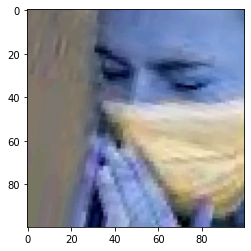

In [22]:
show_example(myDataset[5])

In [23]:
img, label = myDataset[1001]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
tensor(1)


In [24]:
val_size = 1000
train_size = len(myDataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(myDataset, [train_size, val_size])
len(train_ds), len(val_ds)

(9000, 1000)

Label:  Masked (1)


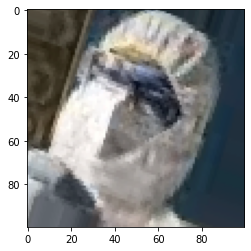

In [25]:
show_example(val_ds[77])

In [26]:
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
batch_size = 32

In [27]:
train_dl = DataLoader(train_ds, batch_size*2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [28]:
#Just to show
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

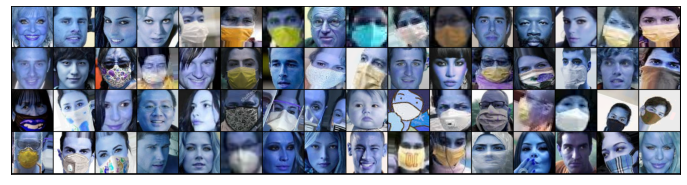

In [29]:
show_batch(val_dl)

In [30]:
#CNN Model
input_size = 100*100
output_size = 2

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
class MaskDetection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #First convolution layer
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            #Second convolution layer
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #First pooling layer
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            #Third convolution layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Fourth convolution layer
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #Second pooling layer
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            
            #Flattening and rectification
            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()

In [34]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [35]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([64, 3, 100, 100])
cuda:0


In [36]:
#Overriding Dataloader methods
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [38]:
for xb, yb in val_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')


In [39]:
#Training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        # Training Phase 
        print('epoch: ', epoch)
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [40]:
# Model (on GPU)
model = MaskDetection()
#model.load_state_dict(torch.load('./output/MaskDetectionFile.pth'))
to_device(model, device)

MaskDetection(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [41]:
#model.load_state_dict(torch.load('./MaskDetectionFile.pth'))
model.eval()

MaskDetection(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [42]:
sum(p.numel() for p in model.parameters())

83055730

In [43]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.49726563692092896, 'val_loss': 0.6931657791137695}]

In [44]:
history = fit(5, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch [0], train_loss: 0.6910, val_loss: 0.6872, val_acc: 0.5521
epoch:  1
Epoch [1], train_loss: 0.6615, val_loss: 0.5768, val_acc: 0.8525
epoch:  2
Epoch [2], train_loss: 0.3199, val_loss: 0.2262, val_acc: 0.9172
epoch:  3
Epoch [3], train_loss: 0.1910, val_loss: 0.2275, val_acc: 0.9043
epoch:  4
Epoch [4], train_loss: 0.1566, val_loss: 0.1373, val_acc: 0.9480


epoch:  0
Epoch [0], train_loss: 0.1250, val_loss: 0.1158, val_acc: 0.9598
epoch:  1
Epoch [1], train_loss: 0.1009, val_loss: 0.1418, val_acc: 0.9480
epoch:  2
Epoch [2], train_loss: 0.0913, val_loss: 0.0900, val_acc: 0.9676
epoch:  3
Epoch [3], train_loss: 0.0933, val_loss: 0.1135, val_acc: 0.9613
epoch:  4
Epoch [4], train_loss: 0.0761, val_loss: 0.0722, val_acc: 0.9725
epoch:  5
Epoch [5], train_loss: 0.0760, val_loss: 0.0763, val_acc: 0.9730
epoch:  6
Epoch [6], train_loss: 0.0700, val_loss: 0.0733, val_acc: 0.9725
epoch:  7
Epoch [7], train_loss: 0.0622, val_loss: 0.0645, val_acc: 0.9764
epoch:  8
Epoch [8], train_loss: 0.0607, val_loss: 0.0860, val_acc: 0.9691
epoch:  9
Epoch [9], train_loss: 0.0605, val_loss: 0.0727, val_acc: 0.9744


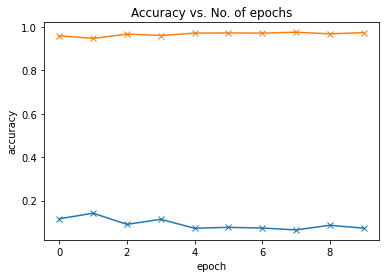

In [45]:
history = fit(10, 1e-3, model, train_dl, val_dl)
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_losses(history)
plot_accuracies(history)

#saving to disk
torch.save(model.state_dict(), './model/MaskDetection.pth')


# Testing
import matplotlib.image as mpimg
def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Immage wasn't read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to('cuda') # Using the same device as the model
    pred = model(img)
    _, preds = torch.max(pred, dim=1)
    print(classes[preds.item()])
    # plt.imshow(img.squeeze(dim=0).permute((1,2,0)).to('cpu'))

    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])
        
def valImage(key, show = True):
    img = val_ds[key][0]
    pred = model(img.unsqueeze(dim=0).to(device))
    _, preds = torch.max(pred, dim=1)
    cv2.imshow('',img.permute(1, 2,0), cmap=cm.bgr)
    print("predicted:",classes[preds.item()])
    print("Actual:",classes[val_ds[key][1]]) 



NotMasked
the image is :NotMasked


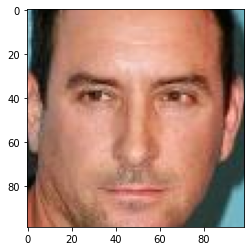

In [48]:
#Give test file path
singleImage('./my_data/Face Mask Dataset/Test/NoMask/WithoutMask/1160.png', show=True)